In [3]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

data_path = '../input/bike-sharing-demand/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

### 데이터 전처리

In [4]:
train = train[train['weather'] != 4]

all_data = pd.concat([train, test], ignore_index=True)

all_data['date'] = all_data['datetime'].apply(lambda x: x.split()[0])

all_data['year'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[0])
all_data['month'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[1])
all_data['hour'] = all_data['datetime'].apply(lambda x: x.split()[1].split(':')[0])
all_data['weekday'] = all_data['date'].apply(lambda dateString: datetime.strptime(dateString, '%Y-%m-%d').weekday())

drop_features = ['casual', 'registered', 'datetime', 'date', 'windspeed', 'month']

all_data = all_data.drop(drop_features, axis=1)

X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]

X_train = X_train.drop(['count'], axis=1)
X_test = X_test.drop(['count'], axis=1)

y = train['count']

In [6]:
def rmsle(y_true, y_pred, convertExp=True):
    # 지수 변환
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)

    # 로그 변환 후 결측값을 0으로 반환
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred+1))

    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

### 하이퍼 파라미터 최적화 (모델 훈련)

In [7]:
from sklearn.ensemble import RandomForestRegressor

# 모델 생성
randomforest_model = RandomForestRegressor()
# 그리드서치 객체 생성
rf_params = {'random_state': [42], 'n_estimators': [100, 120, 140]}
gridsearch_random_forest_model = GridSearchCV(estimator=randomforest_model,
                                              param_grid=rf_params,
                                              scoring=rmsle_scorer,
                                              cv=5)

# 그리드서치 수행
log_y = np.log(y)
gridsearch_random_forest_model.fit(X_train, log_y)
print('최적 하이퍼파라미터 : ', gridsearch_random_forest_model.best_params_)

최적 하이퍼파라미터 :  {'n_estimators': 140, 'random_state': 42}


### 모델 성능 검증

In [8]:
preds = gridsearch_random_forest_model.best_estimator_.predict(X_train)

print(f'랜덤 포레스트 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

랜덤 포레스트 회귀 RMSLE 값 : 0.1126


Text(0.5, 1.0, 'Test Data Distribution')

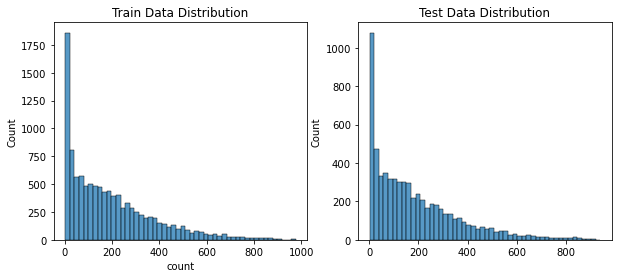

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

randomforest_preds = gridsearch_random_forest_model.best_estimator_.predict(X_test)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(y, bins=50, ax=ax[0])
ax[0].set_title('Train Data Distribution')

sns.histplot(np.exp(randomforest_preds), bins=50, ax=ax[1])
ax[1].set_title('Test Data Distribution')

In [11]:
submission['count'] = np.exp(randomforest_preds)
submission.to_csv('submisson.csv', index=False)